# Solar Power Generation Pre-Processing & Training Data Development

#### Prepared By: Ben Chamblee -  https://github.com/Bench-amblee

## Contents:

* [Introduction](#Introduction)  
* [Imports](#Imports) 
* [Objectives](#Objectives) 
* [Finding Variable Relationships](#Finding_Variable_Relationships) 
     * [DC to AC Power](#DC_to_AC_Power) 
     * [AC Power to Daily Yield](#AC_Power_to_Daily_Yield) 
     * [Module Temperature to DC Power](#Modul_Temperature_to_DC_Power)  
     

* [Prediction Equation](#Prediction_Equation) 
* [Initial "Not Even a Model" Model](#Initial_"Not_Even_a_Model"_Model)  
* [Conclusion](#Conclusion) 

## Introduction

In the last notebook we did exploratory analysis on both the Gandikota and Nashik solar plants. In our analysis we discovered that each array is performing suboptimaley, as compared to industry standard NOCT values for solar arrays, but each indivudal array was consistently suboptimal.

In this notebook, our goal is to develop train and test splits for our model's development. To do this we'll first need to better understand the relationship between temperature of the cell and its power output.

## Imports

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gandikota = pd.read_csv('Data/Plant1_Data_Cleaned.csv')
nashik = pd.read_csv('Data/Plant2_Data_Cleaned.csv')
gandikota_avg = pd.read_csv('Data/gandikota_averages.csv')
nashik_avg = pd.read_csv('Data/nashik_averages.csv')

## Objectives

In order to create test and train splits we'll have to understand what variables will go into our model and how they relate to each other.

- Find the relationship between temperature and power generation
- Develop test and train splits using dummy variables
- Test a model for the next step

## Finding Variable Relationships<a id='Finding_Variable_Relationships'></a>

In [3]:
array1 = gandikota.loc[gandikota['Array_Source_Key']=='1BY6WEcLGh8j5v7']
array1 = array1.reset_index()

Using the NOCT equation we can already calculate the module's temperature using the irradiation and ambient temperature, now we need find a way to calculate total_yield using module_temperature. 

To do this I'm going to add two columns to this df, Temp_Delta and Yield_Delta, once I know how the changes in each variable effect each other I should know their relationship

steps:   
- 1: Find the coefficient of DC and AC Power (AC/DC)
- 2: Calculate the Change in Daily Yield for each 15 mintute interval to see how much total power is generate in that interval
- 3: Find the coefficient of AC and Change in Daily Yield (Daily Yield/AC)
- 4: Find the coefficient of DC and Module Temperature (Temp/DC)
- 5: Formula should look like this: Power = ModuleTemp*(Temp to DC coef)*(DC to AC coef)*(AC to Daily Yield coef)

## DC to AC Power<a id='DC_to_AC_Power'></a>

In [4]:
AC_DC_coef = []
for i in range(len(array1)):
    if array1['DC_Power_kW'][i] == 0:
        coef = 0
    else:
        coef = array1['AC_Power_kW'][i]/array1['DC_Power_kW'][i]
    AC_DC_coef.append(coef)
a = np.array(AC_DC_coef)
a_average = a[np.nonzero(a)].mean()
array1['AC_DC_coef'] = a_average
print('DC Power to AC Power Coefficient',array1['AC_DC_coef'][0])

DC Power to AC Power Coefficient 0.0977288152629642


The AC to DC coversion is around 10x according to these results, let's plot both variables for one day of data just to verify

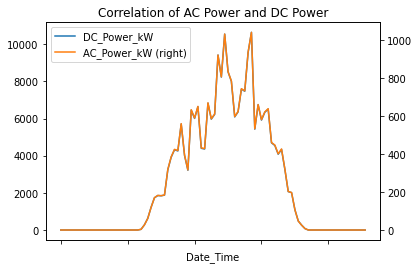

In [5]:
one_day = array1.iloc[0:92]
fig,ax = plt.subplots()
one_day.plot(x='Date_Time',y='DC_Power_kW',ax=ax)
one_day.plot(x='Date_Time',y='AC_Power_kW',ax=ax,secondary_y=True)
plt.title('Correlation of AC Power and DC Power')
ax.set_xticklabels([]);

As we can see by this chart the graphs are identical, the only difference is the y axes which are different by a factor of 10x.

Let see what this relationship looks like with a linear regression

Coefficient: 
 [0.09770993]


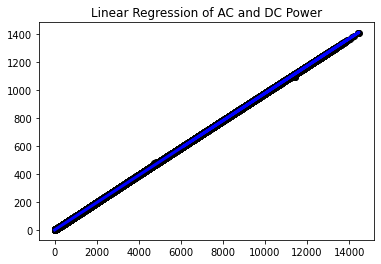

In [6]:
# Train test splits AC and DC Power
from sklearn import linear_model, preprocessing 
from sklearn.model_selection import train_test_split 
X = np.array(gandikota['DC_Power_kW'])
y = np.array(gandikota['AC_Power_kW'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 77)

rModel = linear_model.LinearRegression(normalize=True)

rModel.fit(X_train.reshape(-1,1), y_train)

power_pred = rModel.predict(X_test.reshape(-1,1))

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, power_pred, color='blue', linewidth=3)
plt.title('Linear Regression of AC and DC Power')
print('Coefficient: \n', rModel.coef_);

This isn't an actual machine learning model but simply a way to show this ideal relationship. A comparison of AC and DC Power should look exactly like this because they're essentially measuring the same thing and have the same units (kW)

Now lets move on to our other coefficients

## AC Power to Daily Yield<a id='AC_Power_to_Daily_Yield'></a>

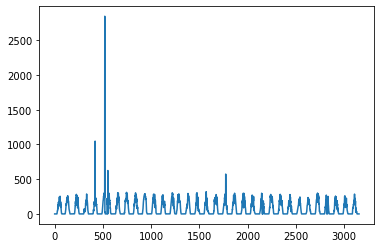

In [7]:
yield_delta = []
for i in range(len(array1)):
    f = i+1
    if f >= len(array1):
        f = f-1
    delta = array1['Daily_Yield_kW'][f] - array1['Daily_Yield_kW'][i]
    if delta < 0:
        delta = 0
        yield_delta.append(delta)
    else:
        yield_delta.append(delta)
array1['yield_delta'] = yield_delta
array1['yield_delta'].plot();

In [8]:
AC_daily_coef = []
for i in range(len(array1)):
    if array1['AC_Power_kW'][i] == 0:
        coef = 0
    else:
        coef = array1['yield_delta'][i]/array1['AC_Power_kW'][i]
    AC_daily_coef.append(coef)
b = np.array(AC_daily_coef)
b_average = b[np.nonzero(b)].mean()
array1['AC_daily_coef'] = b_average
print('AC Power to Change in Daily Yield Coefficient', array1['AC_daily_coef'][0])

AC Power to Change in Daily Yield Coefficient 0.2613734596998696


The Daily_Yeild to AC conversion is around 4x, if we plot the two we should see a 4x factor difference on the y axes like with the previous coefficient.

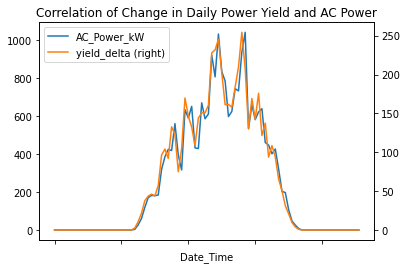

In [9]:
one_day = array1.iloc[0:92]
fig,ax = plt.subplots()
one_day.plot(x='Date_Time',y='AC_Power_kW',ax=ax)
one_day.plot(x='Date_Time',y='yield_delta',ax=ax,secondary_y=True)
plt.title('Correlation of Change in Daily Power Yield and AC Power')
ax.set_xticklabels([]);

the graphs aren't as identical but they're very close, to double check how similar I'll compute the Pearson Correlation Coefficient

In [10]:
import scipy.stats
ac_power = one_day['AC_Power_kW']
yield_delta = one_day['yield_delta']
pearson, p = scipy.stats.pearsonr(ac_power, yield_delta)
print("Pearson's Correlation Coefficient:", pearson, " p-value:", p)

Pearson's Correlation Coefficient: 0.9854029107166744  p-value: 5.309201107246716e-71


With a PCC that close to 1 (meaning a perfect correlation) and a p-value that low (meaning a very low probability of an extreme deviation, we can confirm that these two are statistically very similar

With that in mind we'll stick with the 0.2613 value as our coefficient.

## Module Temperature to DC Power<a id='Module_Temperature_to_DC_Power'></a>

In [11]:
temp_DC_coef = []
for i in range(len(array1)):
    if array1['Module_Temperature_C'][i] == 0:
        coef = 0
    else:
        coef = array1['DC_Power_kW'][i]/array1['Module_Temperature_C'][i]
    temp_DC_coef.append(coef)
c = np.array(temp_DC_coef)
c_average = c[np.nonzero(b)].mean()
array1['temp_DC_coef'] = c_average
print('Module Temperature to DC Power Coefficient: ',array1['temp_DC_coef'][0])

Module Temperature to DC Power Coefficient:  123.9332200911671


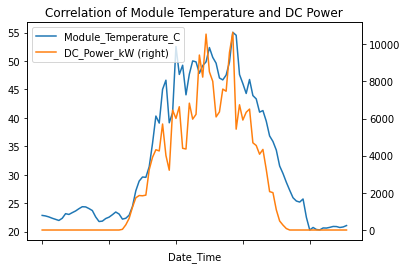

In [12]:
one_day = array1.iloc[0:92]
fig,ax = plt.subplots()
one_day.plot(x='Date_Time',y='Module_Temperature_C',ax=ax)
one_day.plot(x='Date_Time',y='DC_Power_kW',ax=ax,secondary_y=True)
plt.title('Correlation of Module Temperature and DC Power')
ax.set_xticklabels([]);

In [13]:
dc_power = one_day['DC_Power_kW']
temp = one_day['Module_Temperature_C']
pearson, p = scipy.stats.pearsonr(dc_power, temp)
print("Pearson's Correlation Coefficient:", pearson, " p-value:", p)

Pearson's Correlation Coefficient: 0.943501131476236  p-value: 5.975776011596936e-45


These two don't correlate as much as AC power and daily yield do, but the pearson's coefficient is still above 0.5 which, according to https://www.statisticssolutions.com/pearsons-correlation-coefficient/, means that there is a strong linear correlation.

## Prediction Equation<a id='Prediction_Equation'></a>

Now that we have all our coefficients, our equation looks something like this:

![](images/power_equation.png)

where a = 123.933, b = 0.098, and c = 0.261

At least, that's what it looks like for 1 of the 22 arrays in the Gandikota dataset.

lets write a function to find the other 21 so that we can get an equation for the entire power plant, luckily we've already got the plant's averages from the last notebook.

In [14]:
def arraypower(plant_avg):
    avg_ACDC_coef = []
    avg_DailyAC_coef = []
    avg_TempDC_coef = []
    avg_yield_delta = []

    for i in range(len(plant_avg)):
        
        # Change in Daily Yield
        
        f = i+1
        if f >= len(plant_avg):
            f = f-1
        delta = plant_avg['Daily_Yield_kW'][f] - plant_avg['Daily_Yield_kW'][i]
        if delta < 0:
            delta = 0
            avg_yield_delta.append(delta)
        else:
            avg_yield_delta.append(delta)

    plant_avg['yield_delta'] = avg_yield_delta
        
    for i in range(len(plant_avg)):
        
        #DC to AC
        
        if plant_avg['DC_Power_kW'][i] == 0:
            a_coef = 0
        else:
            a_coef = plant_avg['AC_Power_kW'][i]/plant_avg['DC_Power_kW'][i]
        avg_ACDC_coef.append(a_coef)
        
         
        # AC to Change in Daily Yield
        
        if plant_avg['AC_Power_kW'][i] == 0:
            b_coef = 0
        else:
            b_coef = plant_avg['yield_delta'][i]/plant_avg['AC_Power_kW'][i]
        avg_DailyAC_coef.append(b_coef)
        
        # Temp to DC
        
        if plant_avg['Module_Temperature_C'][i] == 0:
            c_coef = 0
        else:
            c_coef = plant_avg['DC_Power_kW'][i]/plant_avg['Module_Temperature_C'][i]
        avg_TempDC_coef.append(c_coef)
             
    a = np.array(avg_ACDC_coef)
    a_average = a[np.nonzero(a)].mean()
    b = np.array(avg_DailyAC_coef)
    b_average = b[np.nonzero(b)].mean()
    c = np.array(avg_TempDC_coef)
    c_average = c[np.nonzero(b)].mean()
    
    coefficients = {'a':a_average,'b':b_average,'c':c_average}
    return coefficients

print('Gandikota Coefficients:')
arraypower(gandikota_avg)
print('')
print('Nashik Coefficients:')
arraypower(nashik_avg)

Gandikota Coefficients:


{'a': 0.09771069317948641, 'b': 0.2655803048723901, 'c': 132.80193678811457}


Nashik Coefficients:


{'a': 0.9766987572570928, 'b': 0.41271866227215875, 'c': 11.09822284792284}

## Initial "Not Even a Model" Model<a id='Initial_"Not_Even_a_Model"_Model'></a>

Now that we have an equation to estimate the power output, we can start to build a model that accurately predicts the total output for the entire plant. We still have the NOCT equation to determine an estimated cell operating temperature, but to test this new equation we'll just use the real operating temperatures.

In [15]:
power_predict = []
coefs = arraypower(gandikota_avg)
a = coefs['a']
b = coefs['b']
c = coefs['c']
for i in range(len(array1)):
    y = array1['Module_Temperature_C'][i]
    x = y*a*b*c
    power_predict.append(x)
array1['power_predict'] = power_predict

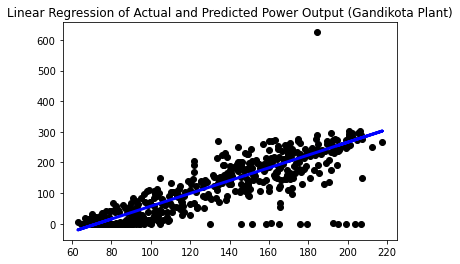

In [16]:
X = np.array(array1['power_predict'])
y = np.array(array1['yield_delta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 77)

rModel = linear_model.LinearRegression(normalize=True)

rModel.fit(X_train.reshape(-1,1), y_train)

power_pred = rModel.predict(X_test.reshape(-1,1))

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, power_pred, color='blue', linewidth=3)
plt.title('Linear Regression of Actual and Predicted Power Output (Gandikota Plant)');

In [17]:
from sklearn.metrics import r2_score
y_pred = rModel.predict(X_test.reshape(-1,1))
print('r2_score: %.2f'
      % r2_score(y_test, y_pred))

r2_score: 0.78


There are a few outliers in this regression that are negatively impacting the r2 score, let's see what happens when we remove those outliers.

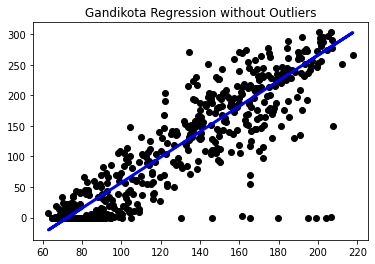

In [18]:
index_1 = []
index_2 = []
for i in range(len(X_test)):
    if y_test[i] > 400:
        index_1.append(i)
    if X_test[i] > 140 and y_test[i] < 50:
        index_2.append(i)
y_test = np.delete(y_test,index_1)
X_test = np.delete(X_test,index_1)
y_test = np.delete(y_test,index_2)
X_test = np.delete(X_test,index_2)

rModel = linear_model.LinearRegression(normalize=True)

rModel.fit(X_train.reshape(-1,1), y_train)

power_pred = rModel.predict(X_test.reshape(-1,1))
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, power_pred, color='blue', linewidth=3)
plt.title('Gandikota Regression without Outliers');

In [19]:
y_pred = rModel.predict(X_test.reshape(-1,1))
print('r2 score: %.2f'
      % r2_score(y_test, y_pred))

r2 score: 0.82


That r2 score is much better than before. Removing about 12 outliers from a dataset with 3000 entries doesn't seem like a big deal but it has a major impact on the r2 score.

This regression isn't perfect, but neither is the equation. For a first try it's actually very good. Let's see how it looks for the Nashik plant

In [20]:
nash_array1 = nashik.loc[nashik['Array_Source_Key']=='4UPUqMRk7TRMgml']
nash_array1 = nash_array1.reset_index()

power_predict = []
coefs = arraypower(nashik_avg)
a = coefs['a']
b = coefs['b']
c = coefs['c']
for i in range(len(nash_array1)):
    y = nash_array1['Module_Temperature_C'][i]
    x = y*a*b*c
    power_predict.append(x)
nash_array1['power_predict'] = power_predict

yield_delta = []
for i in range(len(nash_array1)):
    f = i+1
    if f >= len(nash_array1):
        f = f-1
    delta = nash_array1['Daily_Yield_kW'][f] - nash_array1['Daily_Yield_kW'][i]
    if delta < 0:
        delta = 0
        yield_delta.append(delta)
    else:
        yield_delta.append(delta)
nash_array1['yield_delta'] = yield_delta

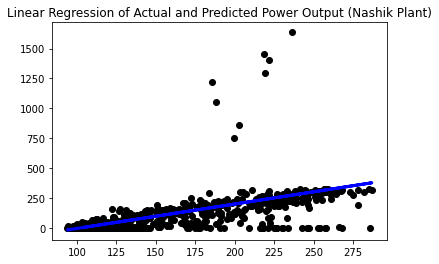

In [21]:
X = np.array(nash_array1['power_predict'])
y = np.array(nash_array1['yield_delta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 77)

rModel = linear_model.LinearRegression(normalize=True)

rModel.fit(X_train.reshape(-1,1), y_train)

power_pred = rModel.predict(X_test.reshape(-1,1))

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, power_pred, color='blue', linewidth=3)
plt.title('Linear Regression of Actual and Predicted Power Output (Nashik Plant)');

In [22]:
y_pred = rModel.predict(X_test.reshape(-1,1))
print('r2 score: %.2f'
      % r2_score(y_test, y_pred))

r2 score: 0.36


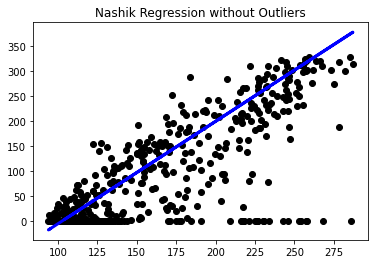

In [23]:
index_1 = []
index_2 = []
for i in range(len(X_test)):
    if y_test[i] > 400:
        index_1.append(i)
    if X_test[i] > 120 and y_test[i] < 20:
        index_2.append(i)
y_test = np.delete(y_test,index_1)
X_test = np.delete(X_test,index_1)
y_test = np.delete(y_test,index_2)
X_test = np.delete(X_test,index_2)

rModel = linear_model.LinearRegression(normalize=True)

rModel.fit(X_train.reshape(-1,1), y_train)

power_pred = rModel.predict(X_test.reshape(-1,1))
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, power_pred, color='blue', linewidth=3)
plt.title('Nashik Regression without Outliers');

In [24]:
y_pred = rModel.predict(X_test.reshape(-1,1))
print('r2 score: %.2f'
      % r2_score(y_test, y_pred))

r2 score: 0.52


Just like with the Gandikota Regression, removing the outliers really improves the r2 score!

## Conclusion

We now have our 2nd equation and a good idea of how we can use a form of regression to accurately estimate the power output of either solar plants.

In combination with the NOCT equation that we found in the last notebook:

![](images/NOCT_calculation.jpg)

![](images/power_equation.png)

We can estimate the output of one array given the temperature outside, all the other variables include the three coefficients and the NOCT have all been found.

Hopefully once we utilize both equations our model will get even more accurate, for now this is what the correlation between our estimate and the actual output looks like:

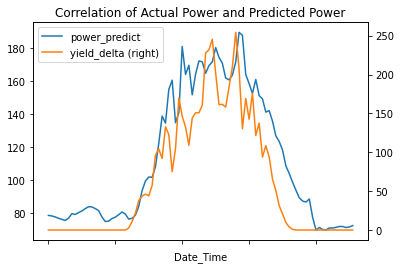

In [35]:
one_day = array1.iloc[0:92]
fig,ax = plt.subplots()
one_day.plot(x='Date_Time',y='power_predict',ax=ax)
one_day.plot(x='Date_Time',y='yield_delta',ax=ax,secondary_y=True)
plt.title('Correlation of Actual Power and Predicted Power')
ax.set_xticklabels([]);

In [26]:
power_predict = one_day['power_predict']
yield_delta = one_day['yield_delta']
pearson, p = scipy.stats.pearsonr(yield_delta, power_predict)
print("Pearson's Correlation Coefficient:", pearson, " p-value:", p)

Pearson's Correlation Coefficient: 0.927956944858388  p-value: 2.3787664265511253e-40


There's still room to improve but this is a great place to start!

In [34]:
gand_coefs = arraypower(gandikota_avg)
nash_coefs = arraypower(nashik_avg)

gand_coefs['a'] = gand_coefs['a']*1.043512


gdf = pd.DataFrame(gand_coefs,index=['a','b','c'])
ndf = pd.DataFrame(nash_coefs,index=['a','b','c']) 

gdf.to_csv(r'Data\gand_coefs.csv',index=False)
ndf.to_csv(r'Data\nash_coefs.csv',index=False)

0.10639886362594093